# 加载常用的库

In [4]:
from torch_snippets import *
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cpu'

# 读取数据

In [5]:
DATASET = os.getenv('APPLE_DATASET_WITH_IMG')
folder_path= DATASET
xmlTrainFolder = os.path.join(folder_path+'train')
xmlTestFolder = os.path.join(folder_path+'test')
train_dir = xmlTrainFolder
test_dir =  xmlTestFolder
root = train_dir

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [6]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), 
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = test_dir
    
tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = tr_ds[10]

# 模型评估

In [7]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)

c:\Users\ADMIN\anaconda3\envs\CLASS_WORK\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\CLASS_WORK\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:17<00:00, 9.76MB/s] 


{'loss_classifier': tensor(1.4915, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.4049, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0040, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0110, grad_fn=<DivBackward0>)}

EPOCH: 0.017  trn_loss: 1.988  trn_loc_loss: 1.511  trn_regr_loss: 0.453  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.009  (8.57s - 2561.22s remaining)
EPOCH: 0.033  trn_loss: 0.745  trn_loc_loss: 0.470  trn_regr_loss: 0.252  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.012  (16.84s - 2508.99s remaining)
EPOCH: 0.050  trn_loss: 0.686  trn_loc_loss: 0.322  trn_regr_loss: 0.355  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (25.26s - 2500.91s remaining)
EPOCH: 0.067  trn_loss: 0.929  trn_loc_loss: 0.506  trn_regr_loss: 0.413  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.007  (33.63s - 2488.74s remaining)
EPOCH: 0.083  trn_loss: 0.407  trn_loc_loss: 0.229  trn_regr_loss: 0.175  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (41.89s - 2471.78s remaining)
EPOCH: 0.100  trn_loss: 0.470  trn_loc_loss: 0.255  trn_regr_loss: 0.201  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.003  (50.38s - 2468.81s remaining)
EPOCH: 0.117  trn_loss: 0.702  trn_

c:\Users\ADMIN\anaconda3\envs\CLASS_WORK\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH: 0.250  trn_loss: 0.354  trn_loc_loss: 0.132  trn_regr_loss: 0.212  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.002  (126.85s - 2410.18s remaining)
EPOCH: 0.267  trn_loss: 0.422  trn_loc_loss: 0.154  trn_regr_loss: 0.257  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.008  (135.24s - 2400.43s remaining)
EPOCH: 0.283  trn_loss: 0.523  trn_loc_loss: 0.191  trn_regr_loss: 0.316  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.004  (143.51s - 2389.06s remaining)
EPOCH: 0.300  trn_loss: 0.509  trn_loc_loss: 0.198  trn_regr_loss: 0.292  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.012  (151.76s - 2377.50s remaining)
EPOCH: 0.317  trn_loss: 0.236  trn_loc_loss: 0.086  trn_regr_loss: 0.146  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (160.21s - 2369.39s remaining)
EPOCH: 0.333  trn_loss: 0.341  trn_loc_loss: 0.126  trn_regr_loss: 0.176  trn_loss_objectness: 0.026  trn_loss_rpn_box_reg: 0.013  (168.53s - 2359.38s remaining)
EPOCH: 0.350  trn_loss: 0.19

100%|██████████| 106/106 [00:00<00:00, 10600.26it/s]


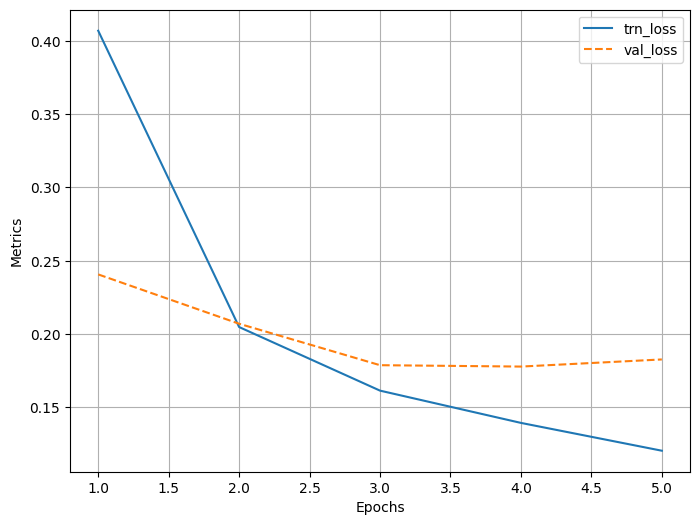

In [8]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

n_epochs = 5
log = Report(n_epochs)
for e in range(n_epochs):
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
    log.report_avgs(e+1)
log.plot_epochs(['trn_loss', 'val_loss'])

# 模型测试

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


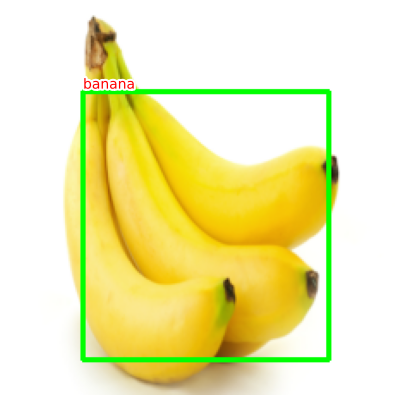

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


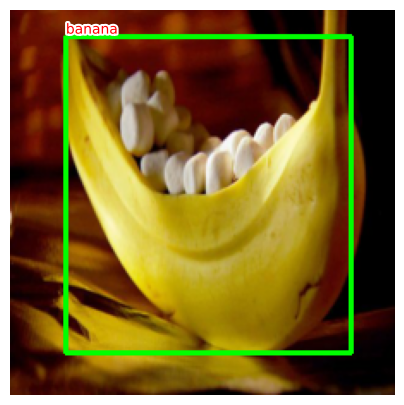

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


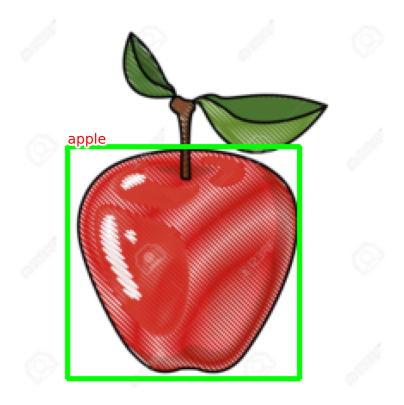

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


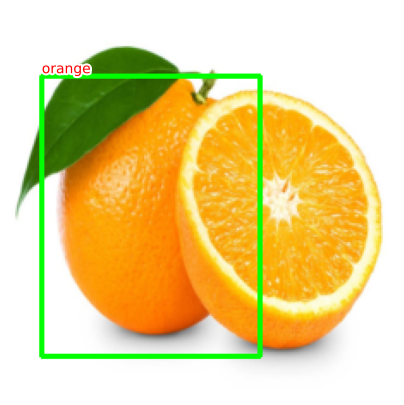

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


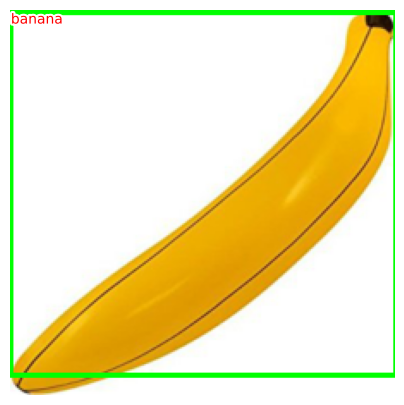

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


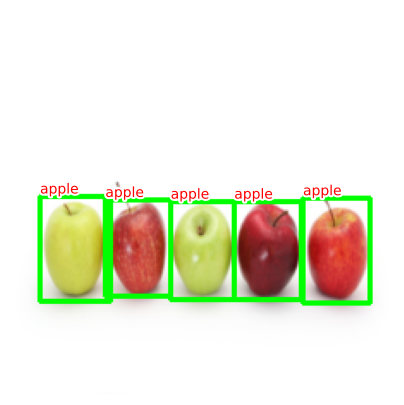

In [10]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 3: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)